## Import Libraries

In [1]:
# importing data
import pandas as pd

# train_test_split & cross validation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score

# creating piplines
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE

# machine learning algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# making graphs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import numpy as np

## Import Data

In [2]:
df = pd.read_pickle('run_pass_df.pkl')

In [3]:
df.head()

,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,drive,qtr,down,goal_to_go,ydstogo,yards_gained,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,wp,Target
3,80.0,900.0,1800.0,3600.0,1.0,1,1.0,0,15,10.0,0,0,3.0,3.0,0.0,0.0,0.0,0.394005,1
4,70.0,862.0,1762.0,3562.0,1.0,1,2.0,0,5,11.0,0,0,3.0,3.0,0.0,0.0,0.0,0.432698,0
5,59.0,826.0,1726.0,3526.0,1.0,1,1.0,0,10,20.0,0,0,3.0,3.0,0.0,0.0,0.0,0.460501,0
6,39.0,790.0,1690.0,3490.0,1.0,1,1.0,0,10,0.0,0,0,3.0,3.0,0.0,0.0,0.0,0.508720,1
7,39.0,785.0,1685.0,3485.0,1.0,1,2.0,0,10,0.0,1,0,3.0,3.0,0.0,0.0,0.0,0.489379,1


In [4]:
# drop yards_gained feature as we are only interested in pre-snap information
df = df.drop('yards_gained', axis=1)

## Prepare Data

In [5]:
# prepare for the train_test_split
X = df.drop('Target', axis=1)
y = df.Target

In [6]:
# perform train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020, test_size=0.20)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70476, 17), (17620, 17), (70476,), (17620,))

## Making Pipelines

In [8]:
# let's create a pipeline to do all of our preprocessing for us

In [9]:
preprocessing = make_column_transformer((OneHotEncoder(), make_column_selector(dtype_include=object)),
                                       (StandardScaler(), make_column_selector(dtype_include=np.number)))

preprocessing

# preprocessing = make_column_transformer((OneHotEncoder(), make_column_selector(dtype_include=object)),
#                                        (StandardScaler(), make_column_selector(dtype_include=np.number),
#                                         SMOTE()))

# preprocessing

ColumnTransformer(transformers=[('onehotencoder', OneHotEncoder(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f3ca75fa0>),
                                ('standardscaler', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f3ca758e0>)])

In [104]:
# fit and transform our preprocessing pipeline to our training data
# X_pipe, y_pipe = preprocessing.fit_transform(X_train, y_train)

ValueError: too many values to unpack (expected 2)

In [10]:
# the next thing we'll do is make separate pipelines for each model we want to test
# each of these pipelines will contain our preprocessing pipeline

dt_pipeline = Pipeline([("pp", preprocessing), ("smote", SMOTE()), ("dt", DecisionTreeClassifier(random_state=2020))])
rf_pipeline = Pipeline([("pp", preprocessing), ("smote", SMOTE()), ("rf", RandomForestClassifier(random_state=2020))])
lr_pipeline = Pipeline([("pp", preprocessing), ("smote", SMOTE()), ("lr", LogisticRegression(random_state=2020))])
et_pipeline = Pipeline([("pp", preprocessing), ("smote", SMOTE()), ("et", ExtraTreesClassifier(random_state=2020))])
kn_pipeline = Pipeline([("pp", preprocessing), ("smote", SMOTE()), ("kn", KNeighborsClassifier())])

## Create Param_Grids

In [11]:
# different param_grids for each pipeline

dt_param_grid = {
    'dt__criterion': ['entropy', 'gini'],
    'dt__splitter': ['best', 'random'],
    'dt__max_depth': [2, 5, 10],
    'dt__max_features': ['auto', 'sqrt', 'log2'],
    'dt__class_weight': ['none', 'balanced']
    
}

rf_param_grid = {
    'rf__n_estimators': [10, 100],
    'rf__max_depth': [2, 5, 10]
    
}

lr_param_grid = {
    'lr__penalty': ['l2'],
    'lr__dual': [False],
    'lr__solver': ['lbfgs'],
    'lr__multi_class': ['multinomial'],
    'lr__n_jobs': [10],
    'lr__C': [0.1]
    
}

et_param_grid = {
    'et__criterion': ['entropy', 'gini'],
    'et__max_depth': [2, 5, 10],
    'et__n_estimators': [10, 100],
    'et__max_features': ['auto', 'sqrt', 'log2'],
    'et__class_weight': ['none', 'balanced']
    
}

kn_param_grid = {
    'kn__n_neighbors': [2, 3],
    'kn__weights': ['uniform', 'distance'],
    'kn__p': [1, 2]
    
}

## LogisticRegression

In [12]:
search_lr = GridSearchCV(lr_pipeline, lr_param_grid, n_jobs=-1)

search_lr.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f3ca75fa0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f3ca758e0>)])),
                                       ('smote', SMOTE()),
                                       ('lr',
                                        LogisticRegression(random_state=2020))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.1], 'lr__dual': [False]

In [13]:
# we can check its best parameters
search_lr.best_params_

{'lr__C': 0.1,
 'lr__dual': False,
 'lr__multi_class': 'multinomial',
 'lr__n_jobs': 10,
 'lr__penalty': 'l2',
 'lr__solver': 'lbfgs'}

In [14]:
# assign best model to a variable using best_estimator_
best_lr_pipeline = search_lr.best_estimator_

In [15]:
# cross validation using the accuracy, precision, recall, and f1 score metric
best_lr_cross_val_acc = cross_val_score(best_lr_pipeline, X_train, y_train, scoring='accuracy')
best_lr_cross_val_prec = cross_val_score(best_lr_pipeline, X_train, y_train, scoring='precision')
best_lr_cross_val_rec = cross_val_score(best_lr_pipeline, X_train, y_train, scoring='recall')
best_lr_cross_val_f1 = cross_val_score(best_lr_pipeline, X_train, y_train, scoring='f1')

## DecisionTree

In [16]:
search_dt = GridSearchCV(dt_pipeline, dt_param_grid, n_jobs=-1)

search_dt.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f3ca75fa0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f3ca758e0>)])),
                                       ('smote', SMOTE()),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=2020))]),
             n_jobs=-1,
             param_grid={'dt__class_weight': ['none', 'b

In [17]:
# we can check its best parameters
search_dt.best_params_

{'dt__class_weight': 'balanced',
 'dt__criterion': 'entropy',
 'dt__max_depth': 2,
 'dt__max_features': 'auto',
 'dt__splitter': 'random'}

In [18]:
# assign best model to a variable using best_estimator_
best_dt_pipeline = search_dt.best_estimator_

In [19]:
# cross validation using the accuracy, precision, recall, and f1 score metric
best_dt_cross_val_acc = cross_val_score(best_dt_pipeline, X_train, y_train, scoring='accuracy')
best_dt_cross_val_prec = cross_val_score(best_dt_pipeline, X_train, y_train, scoring='precision')
best_dt_cross_val_rec = cross_val_score(best_dt_pipeline, X_train, y_train, scoring='recall')
best_dt_cross_val_f1 = cross_val_score(best_dt_pipeline, X_train, y_train, scoring='f1')

## RandomForest

In [20]:
search_rf = GridSearchCV(rf_pipeline, rf_param_grid, n_jobs=-1)

search_rf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f3ca75fa0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f3ca758e0>)])),
                                       ('smote', SMOTE()),
                                       ('rf',
                                        RandomForestClassifier(random_state=2020))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [2, 5, 10],
  

In [21]:
# we can check its best parameters
search_rf.best_params_

{'rf__max_depth': 5, 'rf__n_estimators': 100}

In [22]:
# assign best model to a variable using best_estimator_
best_rf_pipeline = search_rf.best_estimator_

In [23]:
# cross validation using the accuracy, precision, recall, and f1 score metric
best_rf_cross_val_acc = cross_val_score(best_rf_pipeline, X_train, y_train, scoring='accuracy')
best_rf_cross_val_prec = cross_val_score(best_rf_pipeline, X_train, y_train, scoring='precision')
best_rf_cross_val_rec = cross_val_score(best_rf_pipeline, X_train, y_train, scoring='recall')
best_rf_cross_val_f1 = cross_val_score(best_rf_pipeline, X_train, y_train, scoring='f1')

## ExtraTrees

In [24]:
search_et = GridSearchCV(et_pipeline, et_param_grid, n_jobs=-1)

search_et.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f3ca75fa0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f3ca758e0>)])),
                                       ('smote', SMOTE()),
                                       ('et',
                                        ExtraTreesClassifier(random_state=2020))]),
             n_jobs=-1,
             param_grid={'et__class_weight': ['none', 'bal

In [25]:
# we can check its best parameters
search_et.best_params_

{'et__class_weight': 'balanced',
 'et__criterion': 'gini',
 'et__max_depth': 5,
 'et__max_features': 'auto',
 'et__n_estimators': 100}

In [26]:
# assign best model to a variable using best_estimator_
best_et_pipeline = search_et.best_estimator_

In [27]:
# cross validation using the accuracy, precision, recall, and f1 score metric
best_et_cross_val_acc = cross_val_score(best_et_pipeline, X_train, y_train, scoring='accuracy')
best_et_cross_val_prec = cross_val_score(best_et_pipeline, X_train, y_train, scoring='precision')
best_et_cross_val_rec = cross_val_score(best_et_pipeline, X_train, y_train, scoring='recall')
best_et_cross_val_f1 = cross_val_score(best_et_pipeline, X_train, y_train, scoring='f1')

## KNeighbors

In [28]:
search_kn = GridSearchCV(kn_pipeline, kn_param_grid, n_jobs=-1)

search_kn.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pp',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f3ca75fa0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f3ca758e0>)])),
                                       ('smote', SMOTE()),
                                       ('kn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'kn__n_neighbors': [2, 3], 'kn__p': [1, 2],
                         'kn__weights': ['unif

In [29]:
# we can check its best parameters
search_kn.best_params_

{'kn__n_neighbors': 3, 'kn__p': 1, 'kn__weights': 'uniform'}

In [30]:
# assign best model to a variable using best_estimator_
best_kn_pipeline = search_kn.best_estimator_

In [31]:
# cross validation using the accuracy, precision, recall, and f1 score metric
best_kn_cross_val_acc = cross_val_score(best_kn_pipeline, X_train, y_train, scoring='accuracy')
best_kn_cross_val_prec = cross_val_score(best_kn_pipeline, X_train, y_train, scoring='precision')
best_kn_cross_val_rec = cross_val_score(best_kn_pipeline, X_train, y_train, scoring='recall')
best_kn_cross_val_f1 = cross_val_score(best_kn_pipeline, X_train, y_train, scoring='f1')

## Comparison of Models

In [32]:
models = pd.DataFrame({
    'Model': ['LogisticRegression', 'DecisionTree', 'RandomForest', 
              'ExtraTrees', 'KNeighbors'], 
    'Accuracy': [best_lr_cross_val_acc.mean(), best_dt_cross_val_acc.mean(), best_rf_cross_val_acc.mean(), 
               best_et_cross_val_acc.mean(), best_kn_cross_val_acc.mean()], 
    'Precision': [best_lr_cross_val_prec.mean(), best_dt_cross_val_prec.mean(), best_rf_cross_val_prec.mean(), 
               best_et_cross_val_prec.mean(), best_kn_cross_val_prec.mean()], 
    'Recall': [best_lr_cross_val_rec.mean(), best_dt_cross_val_rec.mean(), best_rf_cross_val_rec.mean(), 
               best_et_cross_val_rec.mean(), best_kn_cross_val_rec.mean()],
    'F1 Score': [best_lr_cross_val_f1.mean(), best_dt_cross_val_f1.mean(), best_rf_cross_val_f1.mean(), 
               best_et_cross_val_f1.mean(), best_kn_cross_val_f1.mean()]}) 

In [33]:
models.sort_values('Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
3,ExtraTrees,0.734846,0.782816,0.796422,0.789457
2,RandomForest,0.731724,0.800608,0.750737,0.779516
1,DecisionTree,0.731483,0.774844,0.803937,0.789119
0,LogisticRegression,0.730007,0.805486,0.748263,0.776108
4,KNeighbors,0.676344,0.762889,0.699151,0.731165


In [34]:
models.sort_values('Precision', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
0,LogisticRegression,0.730007,0.805486,0.748263,0.776108
2,RandomForest,0.731724,0.800608,0.750737,0.779516
3,ExtraTrees,0.734846,0.782816,0.796422,0.789457
1,DecisionTree,0.731483,0.774844,0.803937,0.789119
4,KNeighbors,0.676344,0.762889,0.699151,0.731165


In [35]:
models.sort_values('F1 Score', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
3,ExtraTrees,0.734846,0.782816,0.796422,0.789457
1,DecisionTree,0.731483,0.774844,0.803937,0.789119
2,RandomForest,0.731724,0.800608,0.750737,0.779516
0,LogisticRegression,0.730007,0.805486,0.748263,0.776108
4,KNeighbors,0.676344,0.762889,0.699151,0.731165


In [36]:
models.sort_values('Recall', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
1,DecisionTree,0.731483,0.774844,0.803937,0.789119
3,ExtraTrees,0.734846,0.782816,0.796422,0.789457
2,RandomForest,0.731724,0.800608,0.750737,0.779516
0,LogisticRegression,0.730007,0.805486,0.748263,0.776108
4,KNeighbors,0.676344,0.762889,0.699151,0.731165


## Final Model

In [37]:
# refit training data onto best model
best_et_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pp',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f44e25e20>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9f44e25760>)])),
                ('smote', SMOTE()),
                ('et',
                 ExtraTreesClassifier(class_weight='balanced', max_depth=5,
                                      random_state=2020))])

In [38]:
et_cross_val_acc_test = cross_val_score(best_et_pipeline, X_test, y_test, scoring='accuracy').mean()
et_cross_val_prec_test = cross_val_score(best_et_pipeline, X_test, y_test, scoring='precision').mean()
et_cross_val_rec_test = cross_val_score(best_et_pipeline, X_test, y_test, scoring='recall').mean()
et_cross_val_f1_test = cross_val_score(best_et_pipeline, X_test, y_test, scoring='f1').mean()

In [39]:
final_model_comp = pd.DataFrame({
    'Model': ['ExtraTrees Train', 'ExtraTrees Test'], 
    'Accuracy': [best_et_cross_val_acc.mean(), et_cross_val_acc_test], 
    'Precision': [best_et_cross_val_prec.mean(), et_cross_val_prec_test], 
    'Recall': [best_et_cross_val_rec.mean(), et_cross_val_rec_test],
    'F1 Score': [best_et_cross_val_f1.mean(), et_cross_val_f1_test]}) 

In [40]:
final_model_comp

,Model,Accuracy,Precision,Recall,F1 Score
0,ExtraTrees Train,0.734846,0.782816,0.796422,0.789457
1,ExtraTrees Test,0.739501,0.784835,0.801237,0.792859


## ExtraTrees Feature Importance

In [41]:
best_et_pipeline.steps[2][1].feature_importances_

array([0.00176623, 0.01557135, 0.02104798, 0.01387663, 0.00422264,
       0.0086582 , 0.13595939, 0.0019966 , 0.02193684, 0.61806308,
       0.01154374, 0.02815481, 0.00314515, 0.00814761, 0.00905877,
       0.01393049, 0.08292049])

In [42]:
feat_imp_df = pd.DataFrame(best_et_pipeline.steps[2][1].feature_importances_.round(decimals=3), index=X_train.columns)

In [43]:
feat_imp_df.rename({0: 'Importance'}, axis=1, inplace=True)

In [44]:
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=True)

In [45]:
feat_imp_df

,Importance
yardline_100,0.002
goal_to_go,0.002
defteam_timeouts_remaining,0.003
drive,0.004
posteam_score,0.008
qtr,0.009
defteam_score,0.009
no_huddle,0.012
game_seconds_remaining,0.014
score_differential,0.014


<ipython-input-142-70c4b3a0922c>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feat_imp_df.index, fontsize=22)
<ipython-input-142-70c4b3a0922c>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feat_imp_df.Importance, fontsize=22)


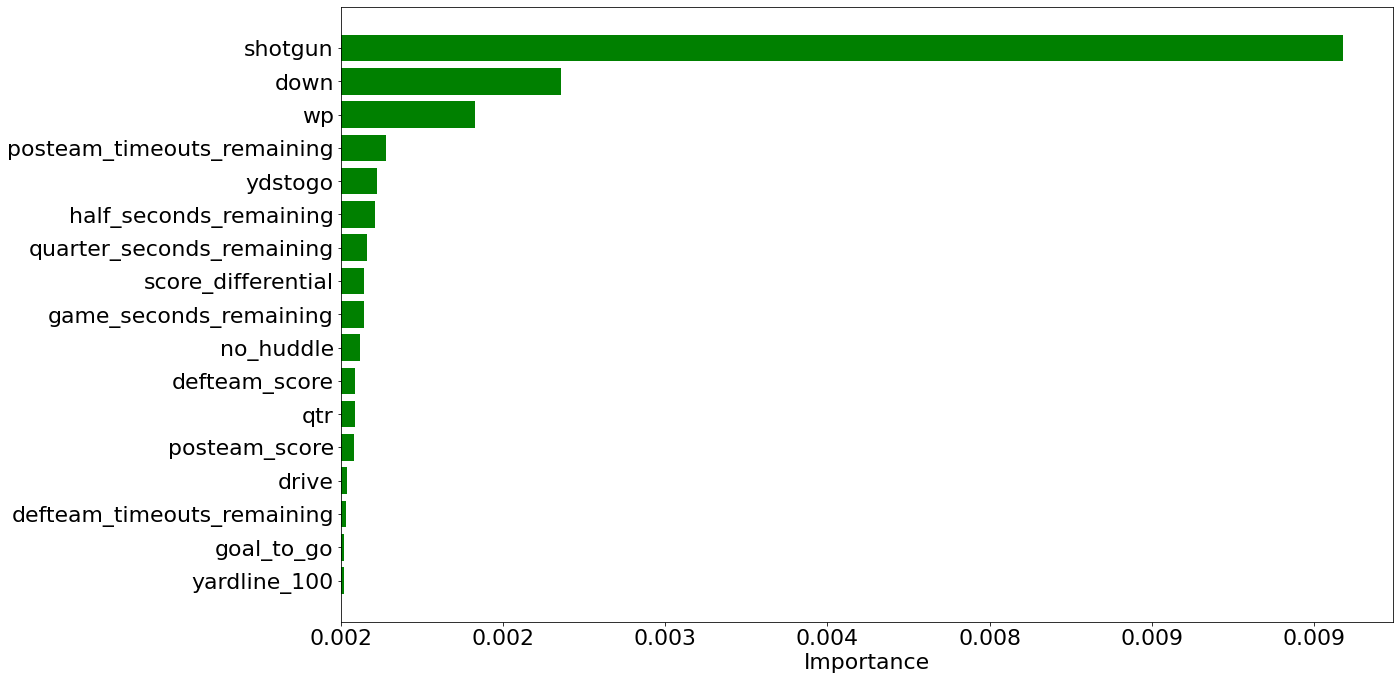

In [142]:
fig,ax = plt.subplots(figsize=(20,10))
plt.barh(feat_imp_df.index, feat_imp_df.Importance, color='g')
# plt.title('Run/Pass Feature Importance', fontsize=25)
plt.xlabel('Importance', fontsize=22)
ax.set_yticklabels(feat_imp_df.index, fontsize=22)
ax.set_xticklabels(feat_imp_df.Importance, fontsize=22)
plt.tight_layout()

plt.savefig('run_pass_features.png')
plt.show()
plt.close()

## Confusion Matrix

In [135]:
from sklearn.metrics import plot_confusion_matrix

def confusion_matrix_info(model, X_test, y_test, save_path=None):
    '''
    Creates a confusion matrix for a given model

    Parameters
    ----------
    model: an estimator

    X_test: testing dataset

    y_test: training dataset

    Returns
    -------
    A confusion matrix of given model
    '''
    fig, axes = plt.subplots(figsize=(13,8))

    #axes.set_title("Model Validation", fontsize=20)
    x_tick_marks = ['Predicted Run', 'Predicted Pass']
    y_tick_marks = ['Actual Run', 'Actual Pass']
    
    plot_confusion_matrix(model, X_test, y_test, ax=axes, cmap='Greens', display_labels=y_tick_marks)

    plt.xticks([0,1], x_tick_marks)
    label_font = {'size':'5'}
    axes.set_xlabel('', fontdict=label_font)
    axes.set_ylabel('', fontdict=label_font)

#     SMALL_SIZE = 25
#     MEDIUM_SIZE = 14
#     BIGGER_SIZE = 16
#     plt.axes('font', size=SMALL_SIZE)          
#     plt.rc('axes', titlesize=SMALL_SIZE)     
#     plt.rc('axes', labelsize=MEDIUM_SIZE)    
#     plt.rc('xtick', labelsize=SMALL_SIZE)   
#     plt.rc('ytick', labelsize=SMALL_SIZE)   
#     plt.rc('legend', fontsize=SMALL_SIZE)   
#     plt.rc('figure', titlesize=BIGGER_SIZE)
    
    plt.tight_layout()
    confusion_matrix = plt.show()

    if save_path:
        plt.savefig(save_path, transparent=True)

    return confusion_matrix, fig



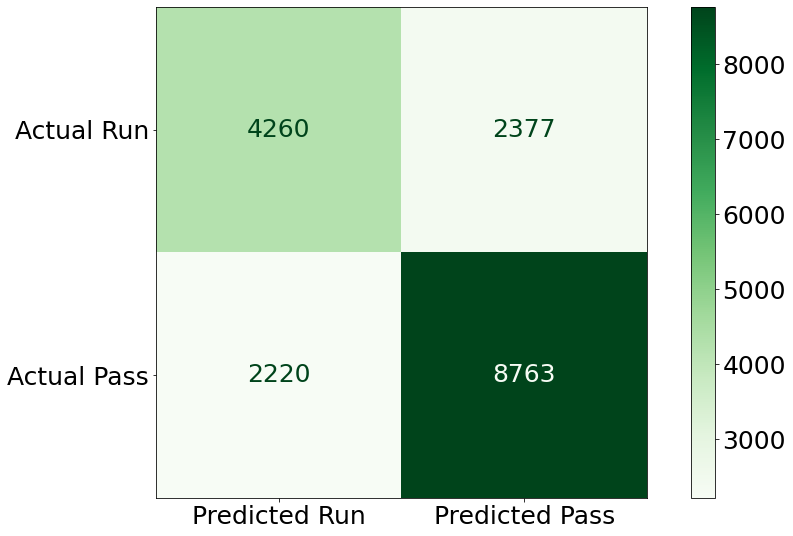

(None, <Figure size 936x576 with 2 Axes>)

<Figure size 432x288 with 0 Axes>

In [136]:
confusion_matrix_info(best_et_pipeline, X_test, y_test, save_path='confusion_matrix.png')

In [123]:
#Generate predictions with the model using our X values
y_pred = best_et_pipeline.predict(X_test)

In [84]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70476, 17), (17620, 17), (70476,), (17620,))

In [124]:
y_pred.shape

(17620,)

In [99]:
from sklearn.metrics import confusion_matrix

#Get the confusion matrix
cf_matrix = confusion_matrix(y_pred, y_test)
print(cf_matrix)

[[4260 2220]
 [2377 8763]]


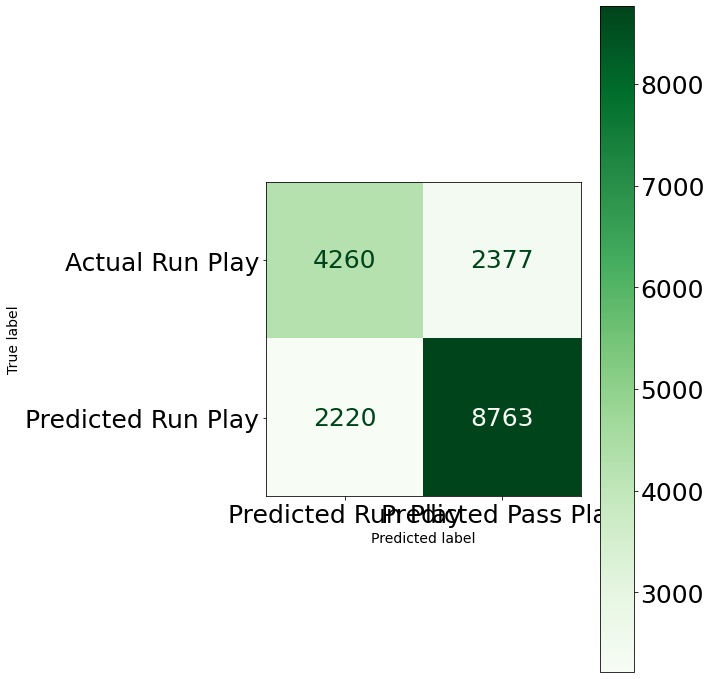

In [134]:
fig, axes = plt.subplots(figsize=(10,10))

x_labels = ['Predicted Run Play', 'Predicted Pass Play']
y_labels = ['Actual Run Play', 'Predicted Run Play']

plot_confusion_matrix(best_et_pipeline, X_test, y_test,cmap='Greens', ax=axes, display_labels=y_labels)

# plt.title('Confusion Matrix')
plt.xticks([0,1], x_labels)
plt.tight_layout()
plt.show()

In [120]:
import seaborn as sns

labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Run', 'Pass']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Greens')

NameError: name 'make_confusion_matrix' is not defined

## Save Final Machine Learning Model With Pickle


In [50]:
import pickle as pkl

file = open('final_pipeline.pkl', 'wb')
pkl.dump(best_et_pipeline, file)
file.close()

In [143]:
df2 = pd.read_pickle('run_pass_df.pkl')

In [144]:
df2.head()

,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,drive,qtr,down,goal_to_go,ydstogo,yards_gained,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,wp,Target
3,80.0,900.0,1800.0,3600.0,1.0,1,1.0,0,15,10.0,0,0,3.0,3.0,0.0,0.0,0.0,0.394005,1
4,70.0,862.0,1762.0,3562.0,1.0,1,2.0,0,5,11.0,0,0,3.0,3.0,0.0,0.0,0.0,0.432698,0
5,59.0,826.0,1726.0,3526.0,1.0,1,1.0,0,10,20.0,0,0,3.0,3.0,0.0,0.0,0.0,0.460501,0
6,39.0,790.0,1690.0,3490.0,1.0,1,1.0,0,10,0.0,0,0,3.0,3.0,0.0,0.0,0.0,0.508720,1
7,39.0,785.0,1685.0,3485.0,1.0,1,2.0,0,10,0.0,1,0,3.0,3.0,0.0,0.0,0.0,0.489379,1


In [152]:
df2['quarter_minutes_remaining'] = round(df2['quarter_seconds_remaining']/60, 2)
df2['half_minutes_remaining'] = round(df2['half_seconds_remaining']/60, 2)
df2['game_minutes_remaining'] = round(df2['game_seconds_remaining']/60, 2)

In [153]:
df2.head()

,yardline_100,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,drive,qtr,down,goal_to_go,ydstogo,yards_gained,...,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,wp,Target,quarter_minutes_remaining,half_minutes_remaining,game_minutes_remaining
3,80.0,900.0,1800.0,3600.0,1.0,1,1.0,0,15,10.0,...,3.0,3.0,0.0,0.0,0.0,0.394005,1,15.00,30.00,60.00
4,70.0,862.0,1762.0,3562.0,1.0,1,2.0,0,5,11.0,...,3.0,3.0,0.0,0.0,0.0,0.432698,0,14.37,29.37,59.37
5,59.0,826.0,1726.0,3526.0,1.0,1,1.0,0,10,20.0,...,3.0,3.0,0.0,0.0,0.0,0.460501,0,13.77,28.77,58.77
6,39.0,790.0,1690.0,3490.0,1.0,1,1.0,0,10,0.0,...,3.0,3.0,0.0,0.0,0.0,0.508720,1,13.17,28.17,58.17
7,39.0,785.0,1685.0,3485.0,1.0,1,2.0,0,10,0.0,...,3.0,3.0,0.0,0.0,0.0,0.489379,1,13.08,28.08,58.08


In [154]:
df2 = df2.drop(['yards_gained', 'quarter_seconds_remaining', 'half_seconds_remaining', 'game_seconds_remaining'], axis=1)

In [155]:
df2.head()

,yardline_100,drive,qtr,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,score_differential,wp,Target,quarter_minutes_remaining,half_minutes_remaining,game_minutes_remaining
3,80.0,1.0,1,1.0,0,15,0,0,3.0,3.0,0.0,0.0,0.0,0.394005,1,15.00,30.00,60.00
4,70.0,1.0,1,2.0,0,5,0,0,3.0,3.0,0.0,0.0,0.0,0.432698,0,14.37,29.37,59.37
5,59.0,1.0,1,1.0,0,10,0,0,3.0,3.0,0.0,0.0,0.0,0.460501,0,13.77,28.77,58.77
6,39.0,1.0,1,1.0,0,10,0,0,3.0,3.0,0.0,0.0,0.0,0.508720,1,13.17,28.17,58.17
7,39.0,1.0,1,2.0,0,10,1,0,3.0,3.0,0.0,0.0,0.0,0.489379,1,13.08,28.08,58.08
